>### ðŸš© *Create a free WhyLabs account to get more value out of whylogs!*<br> 
>*Did you know you can store, visualize, and monitor whylogs profiles with the [WhyLabs Observability Platform](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Image_Logging)? Sign up for a [free WhyLabs account](https://whylabs.ai/whylogs-free-signup?utm_source=whylogs-Github&utm_medium=whylogs-example&utm_campaign=Image_Logging_UDF_Metric) to leverage the power of whylogs and WhyLabs together!*

### Image UDF with custom resolver example

In [ ]:
%pip install 'whylogs[all]' datasets -q

In [12]:
from datasets import load_dataset
# note this is an arbitrary dataset chosen to illustrate logging images
# with a UDF, but you can use your own data or other image dataset.
dataset = load_dataset("hamdan07/UltraSound-Lung")

# Hugging Face dataset, let's see what the keys and structure
# look like
dataset

Resolving data files:   0%|          | 0/300 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
})

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=573x573 at 0x7FAD662E4250>


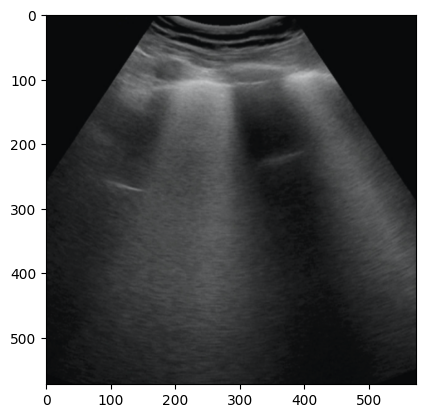

In [6]:
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

# lets create a pandas dataframe to hold the training images,
# we will log these and with whylogs to create a reference profile
df = pd.DataFrame(columns=['image'], data=dataset["train"]['image'])

# let's look at the first image in this dataset
print(df["image"][0])
imshow(np.asarray(df["image"][0]))

In [8]:
from typing import Callable, Dict
from PIL.Image import Image as ImageType
from PIL import ImageFilter

import whylogs as why
from whylogs.core.datatypes import DataType
from whylogs.core.metrics import Metric
from whylogs.core.resolvers import StandardResolver
from whylogs.core.schema import DatasetSchema, ColumnSchema
from whylogs.extras.image_metric import ImageMetric
from whylogs.experimental.core.metrics.udf_metric import UdfMetric, UdfMetricConfig

# helper function to bind a user specified metric name and function to image columns
def udf_metric(name: str, udf: Callable):
  udf_config = UdfMetricConfig(
        udfs={
            name: udf
        },
  )
  # this resolver uses a standard resolver base class, so features logged will get standard metrics
  # but we override the resolution of column "image" to attach the standard ImageMetric
  # and also our UdfMetrics
  class ImageResolver(StandardResolver):
    def resolve(self, name: str, why_type: DataType, column_schema: ColumnSchema) -> Dict[str, Metric]:
      if "image" in name:
        return {
          ImageMetric.get_namespace(): ImageMetric.zero(),
          UdfMetric.get_namespace(): UdfMetric.zero(udf_config)
        }
      return super(ImageResolver, self).resolve(name, why_type, column_schema)
  return ImageResolver()

In [ ]:
# here is an example user defined function that defined a custom metric on images
def edgy_entropy(img: ImageType):
    # do whatever you want with this image and return a numeric type
    # or string (or None), this will result in a user defined metric included in the profile.

    # here we return the built in image entropy from builtin PIL edges
    luminance_edges = img.convert("L").filter(ImageFilter.FIND_EDGES)
    return luminance_edges.entropy()

# Create a DatasetSchema to attach this udf metric to the image column
image_schema = DatasetSchema(resolvers=udf_metric(name="edge_entropy", udf=edgy_entropy))

# now we profile the training df with this schema and get back the profile
results = why.log(df, schema=image_schema)

In [14]:
# lets view the profile's udf metric we added locally before uploading to whylabs
results.view().get_column("image").get_metric("udf").to_summary_dict()


{'edge_entropy:counts/n': 300,
 'edge_entropy:counts/null': 0,
 'edge_entropy:counts/nan': 0,
 'edge_entropy:counts/inf': 0,
 'edge_entropy:types/integral': 0,
 'edge_entropy:types/fractional': 300,
 'edge_entropy:types/boolean': 0,
 'edge_entropy:types/string': 0,
 'edge_entropy:types/object': 0,
 'edge_entropy:types/tensor': 0,
 'edge_entropy:cardinality/est': 300.0002227725499,
 'edge_entropy:cardinality/upper_1': 300.01520155885817,
 'edge_entropy:cardinality/lower_1': 300.0,
 'edge_entropy:distribution/mean': 2.634371055101786,
 'edge_entropy:distribution/stddev': 0.4550609909629663,
 'edge_entropy:distribution/n': 300,
 'edge_entropy:distribution/max': 4.1932956055399275,
 'edge_entropy:distribution/min': 1.2659077301840571,
 'edge_entropy:distribution/q_01': 1.3729952959021117,
 'edge_entropy:distribution/q_05': 1.946231491159389,
 'edge_entropy:distribution/q_10': 2.0503326692987836,
 'edge_entropy:distribution/q_25': 2.39867303519271,
 'edge_entropy:distribution/median': 2.670

In [ ]:
import os
import getpass

# set your org-id here - should be something like "org-xxxx"
print("Enter your WhyLabs Org ID") 
os.environ["WHYLABS_DEFAULT_ORG_ID"] = input()

# set your datased_id (or model_id) here - should be something like "model-xxxx"
print("Enter your WhyLabs Dataset ID")
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = input()
print("Enter your WhyLabs API KEY")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

In [ ]:
# lets upload this to whylabs
results.writer("whylabs").write()